# Model Notebook 

Creating a model to best predict housing prices for a real estate agency.

The function for the model gives the option of a statsmodel summary and a test visualization 

## Loading packages, libraries, functions and variables from the EDA notebook.

In [1]:
#Loading the needed packages, libraries, functions and variables from the EDA notebook.
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate, ShuffleSplit

In [2]:
#Original DataFrame
%store -r df_original

In [3]:
#Cleaned DataFrame — from the EDA notebook
%store -r df_clean

In [4]:
# For consistent randomness
np.random.seed(42)

In [5]:
def df_corr_pairs(dataframe, percentage):
    percentage = percentage / 100    
    df_corr_pairs = dataframe.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_corr_pairs['pairs'] = list(zip(df_corr_pairs.level_0, df_corr_pairs.level_1))
    df_corr_pairs.set_index(['pairs'], inplace = True)
    df_corr_pairs.drop(columns=['level_1', 'level_0'], inplace = True)
    df_corr_pairs.columns = ['cc']
    df_corr_pairs = df_corr_pairs.drop_duplicates()
    df_high_corr_pairs = df_corr_pairs[(df_corr_pairs['cc'] > percentage) & (df_corr_pairs['cc'] < 1)]
    return df_high_corr_pairs

## Modeling

In [6]:
lr = LinearRegression()

In [7]:
# Our model needs to have only numeric variables.
# Using this function, we can drop all columns without numeric varibales.
# We will input this function within our next function.
def only_numeric(data):
    '''returns a dataframe with only numeric values'''
    for column in data.columns:
        if is_numeric_dtype(data[column]) == False:
            data = data.drop(column, axis=1)
        else:
            continue
    return data

In [8]:
# This returns our y and X for any data frame. 
# Uses all the numeric columns, need to pass a string as a target variable.
def get_y_X(data, target):
    data = only_numeric(data) # Making data only columns with numeric values.
    y = data[target] 
    X = data.drop(target, axis=1)
    return y, X

In [9]:
# This function will return a train / test split variables for an X and y. 
def my_train_test(ys, Xs):
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=.2)

    return X_train, X_test, y_train, y_test

In [10]:
# This prediction function is not in effect, work in progress. 
def prediction(ys, Xs):
    y_hat = lr.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    return rmse, y_hat

In [11]:
# Function to compare R2 values and RMSE values of the train and testing models
def train_test_compare(X_tr, X_te, y_tr, y_te):
    model = lr.fit(X_tr, y_tr) # fit the model
    
    #R2 Scores
    train_score = lr.score(X_tr, y_tr)
    test_score = lr.score(X_te, y_te)
    
    #RMSE
    y_hat_train = lr.predict(X_tr)
    y_hat_test = lr.predict(X_te)
    
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_hat_train))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_hat_test))
    
    print(f' training data R2: {train_score}\n testing data R2: {test_score} \
                    \n training data rmse: {train_rmse}\n testing data rmse: {test_rmse}')
    
    #stats model
    stats_summ = input('Do you want a statsmodel summary? (y/n)')
    if stats_summ == 'y':
        inter = model.intercept_
        stats = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
        summary = stats.summary()
        print(summary)
        
    # visualization
    viz = input('Do you want a viz of the test? (y/n)')
    if viz == 'y':
        preds = model.predict(X_te)
        fig, ax = plt.subplots()
        perfect_line = np.arange(y_test.min(), y_test.max())
        ax.plot(perfect_line, linestyle="--", color="orange", label='regression line')
        ax.scatter(y_test, preds, alpha=0.5)
        ax.set_xlabel("Predictors")
        ax.set_ylabel("Predicted Price")
        ax.legend();

    return

In [ ]:
# I am not sure if I am doing the RMSE correctly, but I am pretty confident with the R2

## Model with Test Data

In [12]:
# Using test data to demonstrate
test_data = df_clean.loc[:,['price', 'bedrooms', 'condition', 'sqft_living']]

In [13]:
list(df_clean.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'month',
 'basement',
 'renovated',
 'age']

In [14]:
len(df_clean['basement'])

21597

In [15]:
df_clean['basement'].value_counts()

0    13280
1     8317
Name: basement, dtype: int64

In [16]:
y, X = get_y_X(test_data, 'price')

X_train, X_test, y_train, y_test = my_train_test(y, X)

train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.5163831722955119
 testing data R2: 0.5054004287437498                     
 training data rmse: 256582.88890263447
 testing data rmse: 253781.2371210158
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Model on with Entire Clean DF 

In [17]:
y, X = get_y_X(df_clean, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.6955285374720407
 testing data R2: 0.7188371571036367                     
 training data rmse: 201505.37841518578
 testing data rmse: 199313.1297232731
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Model with Dummy Variables and Binary for Categories

In [18]:
df_clean_dumm = df_clean.copy()

In [19]:
# Get dummies
def add_dummmies(data, column):
    dummy = pd.get_dummies(data[column], drop_first=True)
    dataframe = pd.concat([data, dummy], axis=1)
    dataframe = dataframe.drop(column, axis=1)
    return dataframe

In [20]:
df_clean_dumm['basement'].value_counts()

0    13280
1     8317
Name: basement, dtype: int64

In [21]:
# Get Dummies 
zipcode_dummies = pd.get_dummies(df_clean_dumm['zipcode'], drop_first=True)
view_dummies = pd.get_dummies(df_clean_dumm['view'], drop_first=True)
month_dummies = pd.get_dummies(df_clean_dumm['month'], prefix='month', drop_first=True)
floor_dummies = pd.get_dummies(df_clean_dumm['floors'], prefix='month', drop_first=True)
bedrooms_dummies = pd.get_dummies(df_clean_dumm['bedrooms'], prefix='bed', drop_first=True)
bathrooms_dummies = pd.get_dummies(df_clean_dumm['bathrooms'], prefix='bath', drop_first=True)

#Add to DataFrame
df_clean_dumm = pd.concat([df_clean_dumm, view_dummies, 
                           month_dummies, bedrooms_dummies, bathrooms_dummies, zipcode_dummies], axis=1)

#Drop recurring
df_clean_dumm = df_clean_dumm.drop(['zipcode', 'view', 'floors', 
                                    'month', 'bedrooms', 'bathrooms'], axis=1)

In [22]:
# Binary
df_clean_dumm['waterfront_bin'] = df_clean_dumm['waterfront'].apply(lambda x: 0 if x == 'NO' else 1)

# Drop recurring
df_clean_dumm = df_clean_dumm.drop(['waterfront'], axis=1)

In [23]:
y, X = get_y_X(df_clean_dumm, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8184710077798968
 testing data R2: 0.8009429480478745                     
 training data rmse: 156784.00534284025
 testing data rmse: 162745.8044348799
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Model with non-Luxury houses w/ Dummy Variabls

In [24]:
non_lux = df_clean_dumm.copy()

In [25]:
non_lux = non_lux[non_lux['price'] < 1000000]

In [26]:
y, X = get_y_X(non_lux, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8350180859508469
 testing data R2: 0.8232644935010784                     
 training data rmse: 79473.87287661908
 testing data rmse: 81906.11975200684
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Model with non-Luxury and non-Cheap houses w/ Dummy Variabls

In [27]:
no_lux_cheap = non_lux.copy()

In [28]:
no_lux_cheap = no_lux_cheap[no_lux_cheap['price'] > 100000]

In [29]:
y, X = get_y_X(no_lux_cheap, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8333337847481282
 testing data R2: 0.8266058323132484                     
 training data rmse: 79480.33002181123
 testing data rmse: 81915.22032545178
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Model with non-Luxury houses w/ Dummy Variables - drop useless/high p-val columns

In [30]:
non_lux_drop = non_lux.copy()
non_lux_drop = non_lux_drop.drop(['lat', 'long', 'sqft_lot15'], axis=1)

In [31]:
y, X = get_y_X(non_lux_drop, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8336045160089229
 testing data R2: 0.8269483549114024                     
 training data rmse: 79849.55331810491
 testing data rmse: 80898.51961615118
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Drop Multicollinear Columns

In [32]:
df_corr_pairs(non_lux_drop, 70)

,cc
pairs,
"(sqft_living15, sqft_living)",0.731907


In [33]:
non_lux_drop_more = non_lux_drop.copy()

In [34]:
non_lux_drop_more = non_lux_drop_more.drop(['sqft_living15'], axis=1)

In [35]:
y, X = get_y_X(non_lux_drop_more, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8301462536809249
 testing data R2: 0.8201289907881151                     
 training data rmse: 80746.00272916025
 testing data rmse: 82185.07543762107
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


## Log Transform & Scaling

In [36]:
scale_test = non_lux_drop.copy()

In [37]:
y, X = get_y_X(scale_test, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.835311462368065
 testing data R2: 0.8208019020242194                     
 training data rmse: 79444.6893182053
 testing data rmse: 82300.16373473241
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


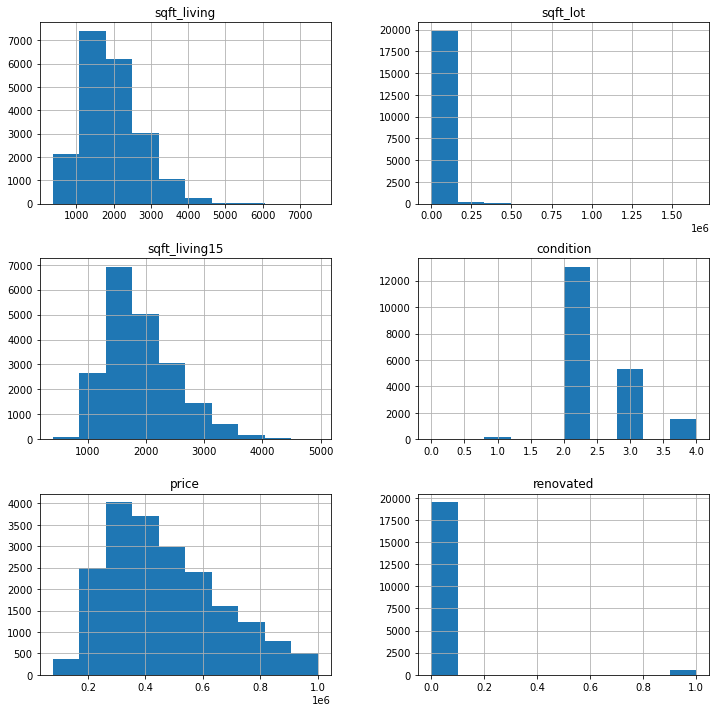

In [39]:
scale_test[['sqft_living', 'sqft_lot', 'sqft_living15', 
            'condition', 'price', 'renovated']].hist(figsize  = [12, 12]); 

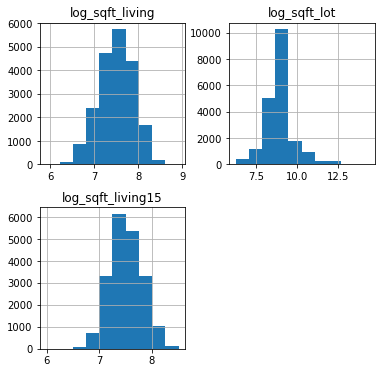

In [40]:
# run on sqft_living, sqft_lot, and sqft_living15
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(scale_test['sqft_living'])
data_log['log_sqft_lot'] = np.log(scale_test['sqft_lot'])
data_log['log_sqft_living15'] = np.log(scale_test['sqft_living15'])
data_log.hist(figsize  = [6, 6]);

In [41]:
#concat
scale_test = pd.concat([scale_test, data_log], axis=1)
scale_test = scale_test.drop(['sqft_living', 'sqft_lot', 'sqft_living15'], axis=1)

In [42]:
y, X = get_y_X(scale_test, 'price')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8306970776186967
 testing data R2: 0.8278321793389558                     
 training data rmse: 80260.20277030664
 testing data rmse: 81831.74263729154
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


In [43]:
# log price — FAILED
price_log = pd.DataFrame([])
price_log['price_log'] = np.log(scale_test['price'])
scale_test = pd.concat([scale_test, price_log], axis=1)
scale_test = scale_test.drop(['price'], axis=1)

In [44]:
y, X = get_y_X(scale_test, 'price_log')
X_train, X_test, y_train, y_test = my_train_test(y, X)
train_test_compare(X_train, X_test, y_train, y_test)

 training data R2: 0.8447540248963261
 testing data R2: 0.8360868933889116                     
 training data rmse: 0.17111110219126777
 testing data rmse: 0.17477195858356762
Do you want a statsmodel summary? (y/n)n
Do you want a viz of the test? (y/n)n


In [45]:
#scaling
StandardScaler().fit_transform(X_train)

array([[ 0.91980786,  0.48920813,  1.30984145, ...,  0.75337269,
         0.74315869,  0.8889442 ],
       [-0.63185543,  0.48920813,  1.30984145, ...,  0.96329211,
        -1.32868615,  0.08579828],
       [-0.63185543,  0.48920813,  1.30984145, ..., -0.75156333,
        -2.44010909, -0.98078763],
       ...,
       [-0.63185543,  0.48920813,  1.30984145, ..., -0.04851785,
        -1.85943326, -0.07566261],
       [ 0.91980786, -1.48542494, -0.76345118, ..., -2.17914369,
        -0.59300618, -0.52856571],
       [-0.63185543, -0.4981084 ,  1.30984145, ..., -0.36770752,
        -1.32306258, -0.44516236]])

## RFECV 

In [ ]:
#create splitter
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)


# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = 





(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(lr.columns):
    print(f"{col}: {selector.support_[index]}")